## Data Exploration

To quote the data source:

"This data set contains statistics, in arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas."

In [156]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv",index_col='City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


Firstly, let's rename the City column to State, because that's what it is.

In [157]:
df.rename(columns={'City': 'State'}, inplace=True)

Now for a look at the data types.

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


And a check for missing values.

In [159]:
# Count missing values
missing = df.isnull().sum()
missing_data = pd.DataFrame(missing, columns=["missing"])
missing_data

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


With no missing values, it's time to have a look at the data in statistical terms.

In [160]:
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose()
selected_stats

,mean,std,min,max
Murder,7.788,4.356,0.800,17.400
Assault,170.760,83.338,45.000,337.000
UrbanPop,65.540,14.475,32.000,91.000
Rape,21.232,9.366,7.300,46.000


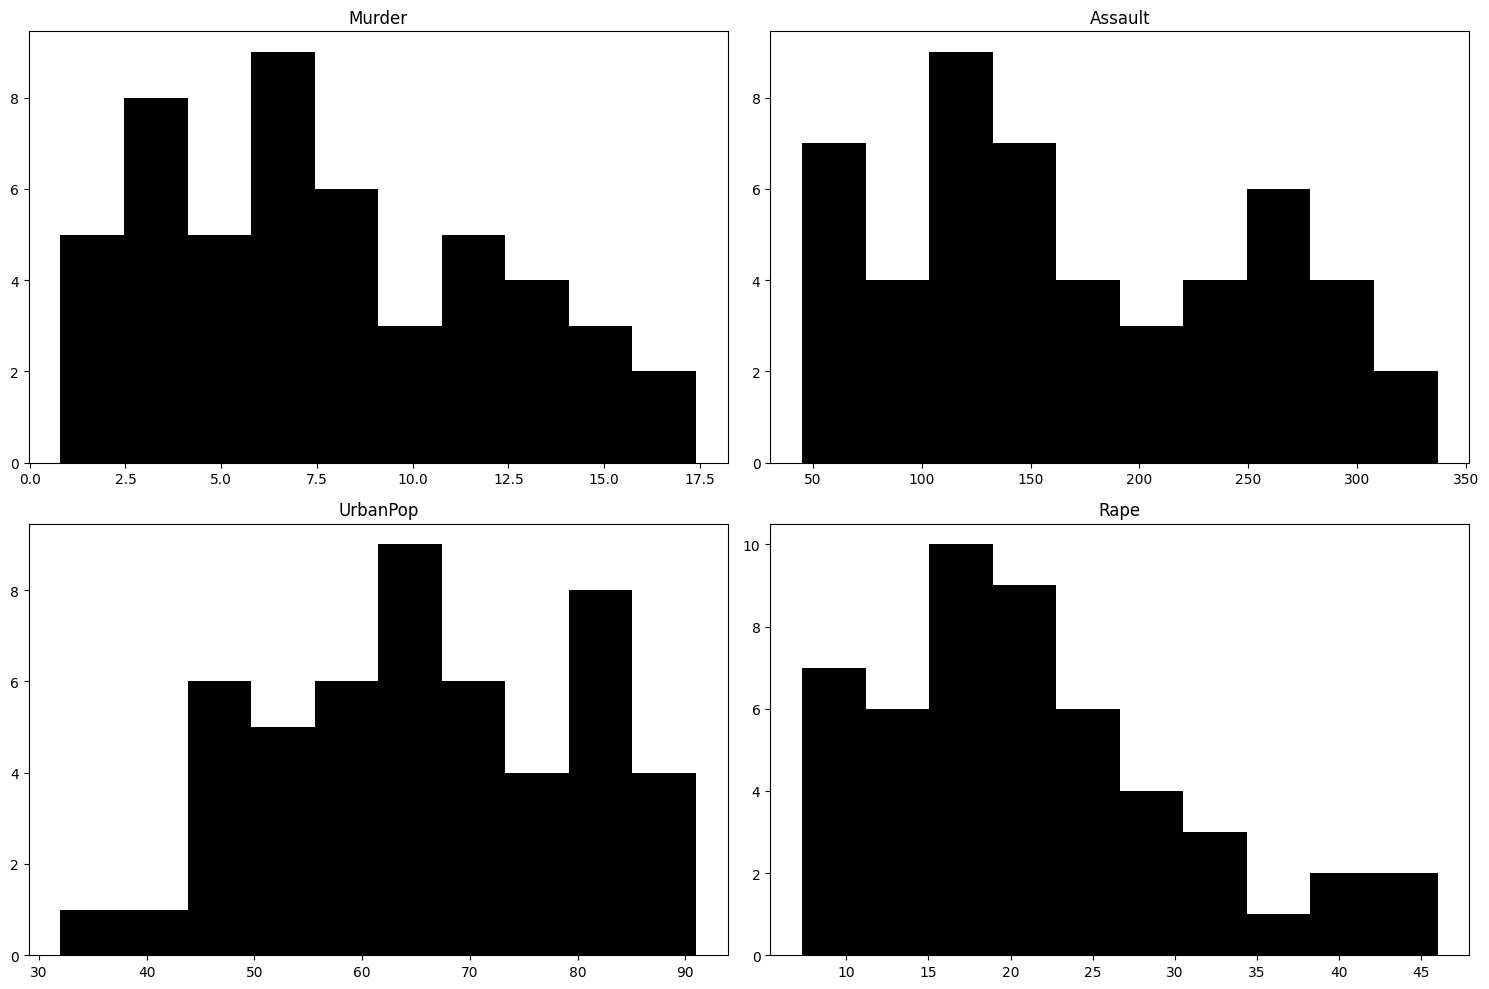

In [161]:
histograms = df.hist(color='black', grid=False, figsize=(15, 10))
plt.tight_layout()
plt.show()

Clearly this data will need to be scaled before use, as the larger data in the assault figures will disproportionately impact the data otherwise

Now, correlation analysis.

## Correlation Analysis

In [162]:
countries = df.index
corr_df = df.corr()
labels = corr_df.columns

correlations = corr_df.corr()

<AxesSubplot: >

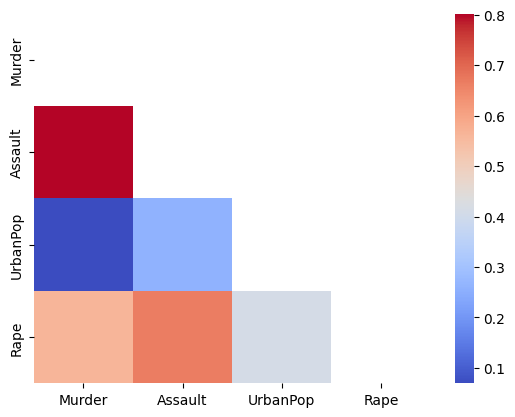

In [163]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")


Assault, Murder and Rape are all strongly correlated with each other, which makes sense in a wider context of more violent crimes.

Urban Population is more weakly correlated with the crime, though still positively correlated.

It would make intuitive sense that other socioeconomic factors would have more impact on crime rates than urban population does, wealth/income being an obvious one.

Because of the strong correlations in the data, Principal Component Analysis will now be used.

## PCA

In [164]:
from sklearn.decomposition import PCA #run again if it does not converge the first time

np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802,11.448,-2.495,2.408
1,92.827,17.983,20.127,-4.094
2,124.068,-8.830,-1.687,-4.354
3,18.340,16.704,0.210,-0.521
4,107.423,-22.520,6.746,-2.812


In [165]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [166]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [167]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


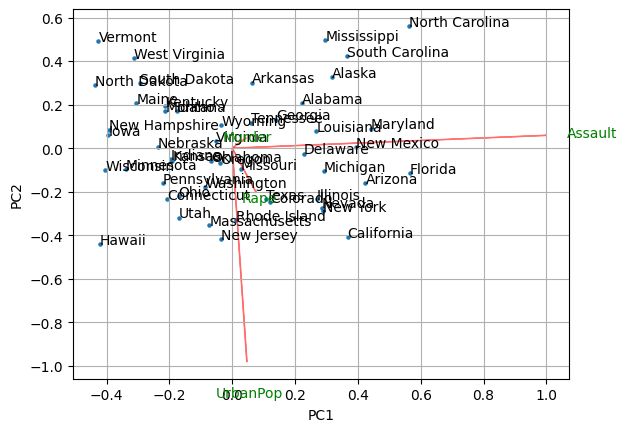

In [168]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = countries[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(countries))
plt.show()

Assault has the highest importance to Principal Component 1 and Urban Population has the highest importance to Principal Component 2.

To quantify this in a table:

In [169]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


This backs up the results from the biplot above. We saw earlier that Assault and Urban Population had the highest mean values and standard deviations, so we need to standardise our data to prevent these features from dominating our analysis.

### Standardised data

We standardise the data so that some features do not swamp the others.

In [170]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


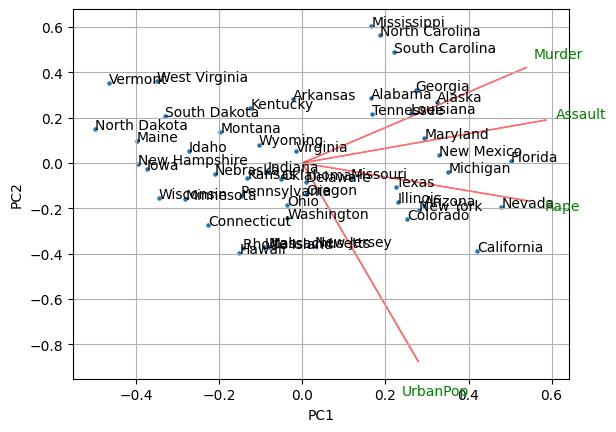

In [171]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

The three crimes have high positive loading values into Principle Component 1, which suggests that Principle Component 1 can be thought of as summarising the violent crime rate in these states.

Urban Population has the largest loading value into Principle Component 2 by far, which broadly suggests that Principle Component 2 can be thought of as the proportion of the state's poulation that live in rural areas.

In [172]:
pc1 = abs( std_pca.components_[0] )
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Text(0.5, 1.0, 'Cumulative Explained Variance')

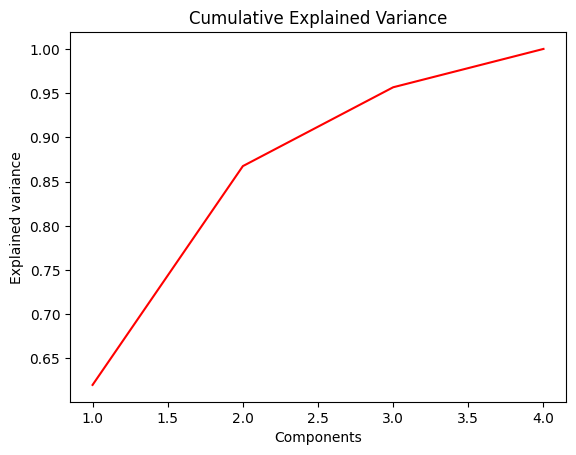

In [173]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

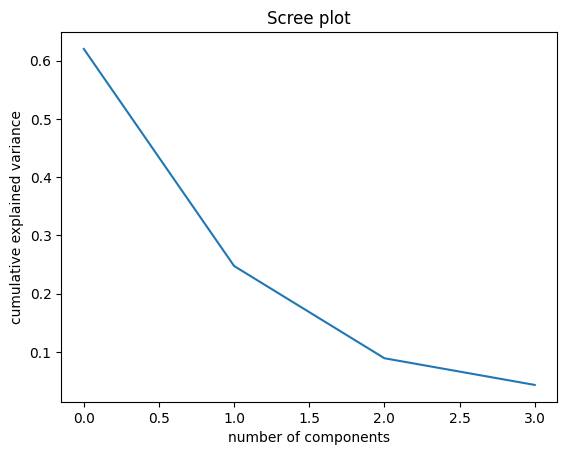

In [174]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 2 Principal Components explain just under 90% of the variance, so we will use 2. With this the dimensionality of the data has been reduced from 4 variables to 2.

In [175]:
pca_df = pd.DataFrame(X_std_trans[:,0:2], index = df.index)
pca_df.head()

,0,1
City,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


## Hierarchical clustering

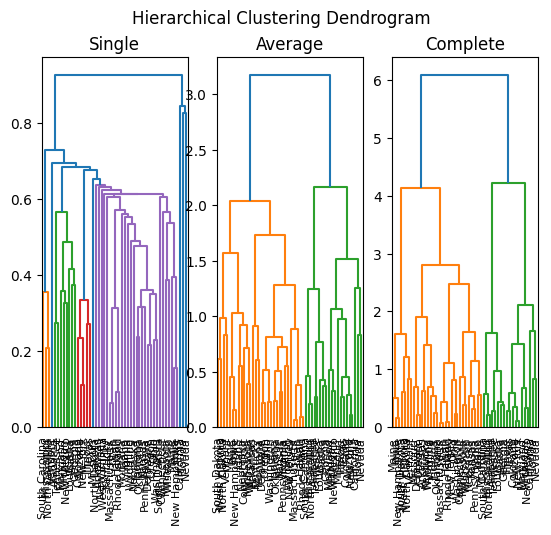

In [176]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

Is it clear from the dendogram above that the complete linkage method creates the most balanced dispersion of clusters, so the complete linkage method will be used.

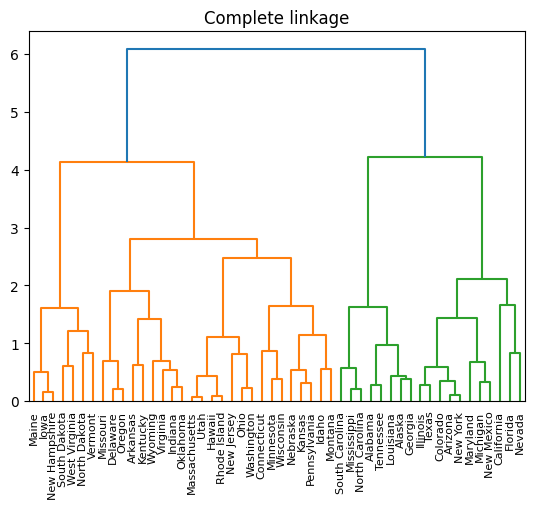

In [177]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

Hierarchical clustering has split the data into two clusters, of sizes 31 and 19 respectively. These can be broadly summarised as the states with low violent crime rates, and the states with high violent crime rates.

### K-means clustering

Text(0, 0.5, 'Dim 1')

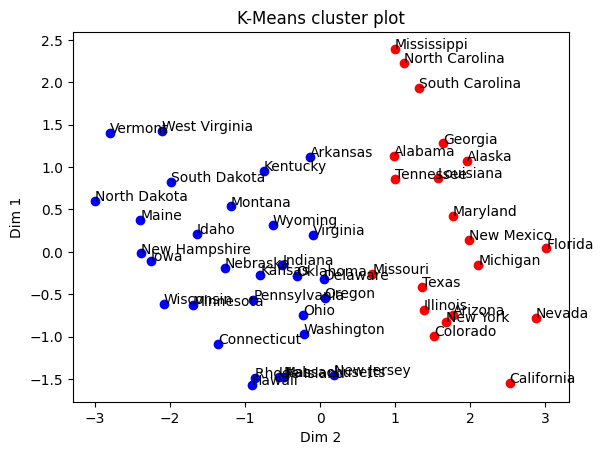

In [178]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=22)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = countries[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

Just as the hierarchical clustering separated the data into two clusters, the K-means clustering has produced an almost identical pair of clusters.

Again, these can broadly be thought of as states with high levels of violent crime and states with low levels of violent crime.

Given that the initial data showed that the violent crime features were strongly positively correlated with each other, but weakly correlated with the Urban Population data, it is hard to see how else the data could have been clustered.

Looking at the states, it would appear that violent crimes are most prevalent in the poorest states (Mississippi, Lousiana, Alabama etc) and the States with the largest cities (New York, California etc) - perhaps as larger cities generally contain the poorest areas, and these areas could be elevating the violent crime rates. Further analysis on more data would be required to confirm this.